In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB6,EfficientNetB7,InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report
import keras

In [ ]:
classes=[]
filename=r"/content/drive/MyDrive/Data/MRI Images/"
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']


In [ ]:
X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)):
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)        


100%|██████████| 105/105 [00:00<00:00, 114.75it/s]


In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

print(y_train)

[3 3 2 ... 3 3 0]


In [ ]:
EfficientNet=EfficientNetB7(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

258088960/258076736 [==============================] - 2s 0us/step


In [ ]:
tf.random.set_seed(79)
model = EfficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
opt = Adam(
    learning_rate=0.000023,
    epsilon=1e-08,
    clipnorm=1.0)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 


In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 161, 161, 3)  0           ['normalization[0][0]']      

In [ ]:
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=70,
    batch_size=8,callbacks=[early_stopping_cb])


Epoch 1/70
348/348 [==============================] - 201s 358ms/step - loss: 0.8953 - accuracy: 0.6477 - val_loss: 0.7592 - val_accuracy: 0.7520
Epoch 2/70
348/348 [==============================] - 118s 338ms/step - loss: 0.4562 - accuracy: 0.8408 - val_loss: 0.3604 - val_accuracy: 0.9228
Epoch 3/70
348/348 [==============================] - 116s 334ms/step - loss: 0.2733 - accuracy: 0.9094 - val_loss: 0.1862 - val_accuracy: 0.9492
Epoch 4/70
348/348 [==============================] - 116s 334ms/step - loss: 0.1701 - accuracy: 0.9421 - val_loss: 0.1597 - val_accuracy: 0.9492
Epoch 5/70
348/348 [==============================] - 116s 333ms/step - loss: 0.1208 - accuracy: 0.9619 - val_loss: 0.1639 - val_accuracy: 0.9573
Epoch 6/70
348/348 [==============================] - 116s 334ms/step - loss: 0.1060 - accuracy: 0.9633 - val_loss: 0.0975 - val_accuracy: 0.9736
Epoch 7/70
348/348 [==============================] - 116s 334ms/step - loss: 0.0720 - accuracy: 0.9784 - val_loss: 0.1056 -

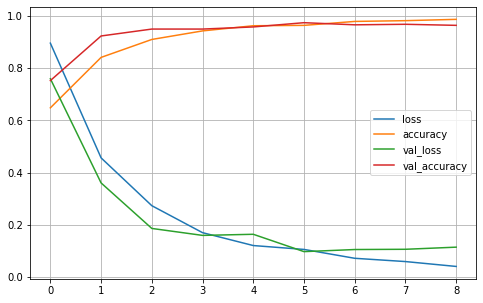

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)


In [ ]:
loss, accuracy = model.evaluate(X_test,y_test)


16/16 [==============================] - 5s 257ms/step - loss: 0.0975 - accuracy: 0.9736


In [ ]:
print('Accuracy: %f' % (accuracy*100))

Accuracy: 97.357726


In [ ]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 97.358 
 loss : 0.098


In [ ]:
y_test_labels=lb.inverse_transform(y_test)

pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred)

In [ ]:
pd.Series(pred_labels).value_counts()

glioma_tumor        139
meningioma_tumor    137
pituitary_tumor     135
no_tumor             81
dtype: int64

Text(70.8, 0.5, 'Predicted class')

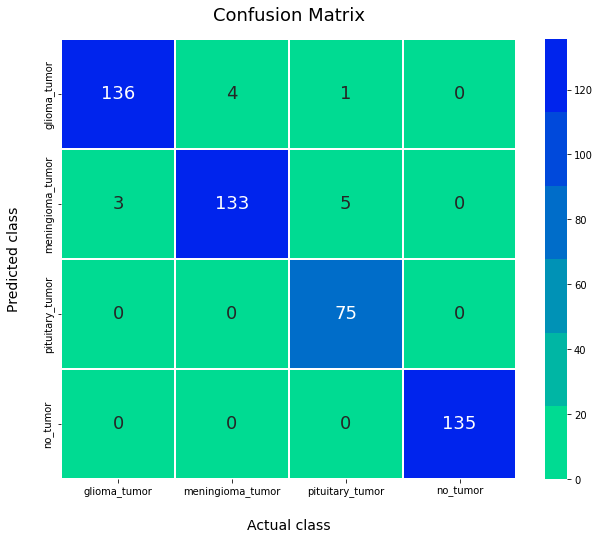

In [ ]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)

ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

In [ ]:
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.96      0.97       141
meningioma_tumor       0.97      0.94      0.96       141
 pituitary_tumor       0.93      1.00      0.96        75
        no_tumor       1.00      1.00      1.00       135

        accuracy                           0.97       492
       macro avg       0.97      0.98      0.97       492
    weighted avg       0.97      0.97      0.97       492

